
# NLP in Machine Learning

¡Buenos días! El challenge de hoy consistirá en un ejercicio práctico sencillo de NLP. Para ello lo primero que se va a necesitar es un conjunto de datos. En este caso nosotros os proponemos el siguiente:

[Canciones español](https://www.kaggle.com/smunoz3801/9325-letras-de-rap-en-espaol)

La idea del conjunto de datos es que seamos capaces de limpiar adecuadamente el texto, hacer representaciones relevantes, sacar información relevante sobre el vocabulario y finalmente entrenar un clasificador.


¡A por ello!

#### Carga de librerías básicas, the usual stuff

In [80]:
import re   
from sklearn.datasets import load_files 
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import nltk
#nltk.download('stopwords')     <- Os tocará descargarlo la primera vez
from nltk.corpus import stopwords
import pandas as pd
import numpy as np

#### Carga de datos, next!

In [27]:
df = pd.read_csv('./data/hhgroups_merge_28_05.csv')

In [20]:
df.head()

,id,artista,cancion,album,letra,anyo,visitas
0,0,Denom,Machete (con Jarfaiter y Gente jodida),Medicina,"Para su nuevo disco ""Medicina"", Denom ha vuelt...",2019,126
1,1,Denom,Vacío (con Ivo Incuerdo),Medicina,"[Denom]\nYo que quería, yo que pedía vida,\nSe...",2019,361
2,2,Denom,El orgullo es fiel (con Juancho Marqués y Elio...,Medicina,"""El orgullo es fiel"" es uno de los cortes incl...",2019,262
3,3,Denom,Mueve mueve (con Fernandocosta),Medicina,"[Estribillo: Denom] (x2)\nMueve, mueve, mueve,...",2019,578
4,4,Jaro Desperdizio,Insomnia,"Sin álbum, es un vídeo suelto","[Estribillo]\nY en esta noche, ¿Quién me arrop...",2019,219


## Vamos a hacernos un precioso problema con esto

Ya sabemos que hay varios "individuos" por llamarlos de alguna manera  ;)  en este conjunto de datos. Por simplificar, vamos a elegir a un par de ellos a ver si somos capaces de entrenar un mero clasificador

In [21]:
df.artista.value_counts()

Porta                             157
SFDK                              140
Nach                              128
Toteking                          101
El Chojin                          91
                                 ... 
TFR Crew                            1
FK Crew                             1
Luisaker                            1
Dollar Selmouni y Dani Heredia      1
Drnd                                1
Name: artista, Length: 1609, dtype: int64

Pues ya que son de los que más observaciones tenemos, elegimos a Porta y a SFDK

In [29]:
df = df[(df.artista == 'Porta') | (df.artista == 'SFDK')]
df = df.reset_index(drop=True) #importante, resetead el índice para que todo quede en orden

### Separar por un lado los textos y por otro el artista

In [30]:
textos = df.letra
artista = df.artista

## 1 - Exploración de los textos


#### ¿Nulos?

In [46]:
textos.isnull().sum()

0

#### ¿Hay anciones repetidas en el conjunto?

In [45]:
print(len(textos.unique()),len(textos))

297 297


#### Imprime un texto a ver que pinta tiene

In [51]:
print(textos[0])

[Estribillo: Uve Sad]
Nunca pensé lo que sería,
Me desvíe, tracé otra vía,
¿Merezco esto? Mi muerte en vida,
Ayúdame a encontrar otra salida,
Nunca pensé lo que sería,
Me desvíe, tracé otra vía,
¿Merezco esto? Mi muerte en vida,
Ayúdame a encontrar otra salida.


[Uve Sad]
Antes de dormir me angustiaré,
Diré que ha sido mi culpa,
Te llamaré, te haré saber,
Que no he gana'o tus disculpas,
Aunque sepa que todo es mentira,
A pesar que la herida se irrita,
Sigo mirando hacia arriba,
Pensando en el día en que acabé mi vida,
Mírame, ya lo sé, no estoy bien,
Esto es algo que no puedes resolver,
¡Ey! Fíjate ya no me puedo sostener,
¡Ey! Tuve fe, no me alejé, siempre te di mi cien,
¡Ey! Y ahora que ya no quiero mirar más atrás,
Tal vez después de tanto tiempo pueda respirar,
¡Ey! Pero no es así y es que sigo mal,
Ya sé que es por mí, no consigo amar.


[Estribillo: Uve Sad]
Nunca pensé lo que sería,
Me desvíe, tracé otra vía,
¿Merezco esto? Mi muerte en vida,
Ayúdame a encontrar otra salida,
Nu

#### Implementar la función de limpiado de texto

La idea de esta función es que dado un texto lo procese adecuadamente para su posterior tratamiento con TF-IDF, tal y como habéis visto en la teoría. Para ello nos vamos a basar en el texto que hemos impreso antes para ver qué cosas especiales tiene. Para esta función recomendamos usar los paquetes `re` y `unidecode`

In [59]:
def doClean(text):   
    
    # Quitar las expresiones entre llaves que denotan las partes de la canción
    a = re.sub(r'\[.+\]', ' ', str(text))
    # Quitar las aclaraciones entre paréntesis
    a = re.sub(r'\(.+\)', ' ', str(a))
    # Quitar acentos 
    import unidecode
    a = unidecode.unidecode(a)
    # Quitar aquello que no sean palabras o cosa que se le parezca
    a = re.sub(r'\W', ' ', a)
    # Quitar espacios extra en caso de haber
    a = re.sub(r'\s+', ' ', a, flags=re.I)
    # Pasar el texto a minúsulas
    a = a.lower()
    # retirar stopwords
    a = a.split()
    a = [ word for word in a if word not in stopwords.words('spanish')]
    a = " ".join(a)

    return a

Aplicar la función a nuestro conjunto de textos es tan sencillo como esto:

In [60]:
textos_limpios = textos.apply(doClean)

Imprime uno, a ver qué tal ha quedado 

In [72]:
textos_limpios[0]

'nunca pense seria desvie trace via merezco muerte vida ayudame encontrar salida nunca pense seria desvie trace via merezco muerte vida ayudame encontrar salida dormir angustiare dire sido culpa llamare hare saber gana disculpas aunque sepa mentira pesar herida irrita sigo mirando hacia arriba pensando dia acabe vida mirame bien puedes resolver ey fijate puedo sostener ey fe aleje siempre di cien ey ahora quiero mirar mas atras tal vez despues tiempo pueda respirar ey asi sigo mal consigo amar nunca pense seria desvie trace via merezco muerte vida ayudame encontrar salida nunca pense seria desvie trace via merezco muerte vida ayudame encontrar salida hace deje callar quiza da igual puedan pensar suda tiempo pa dudas vida cruda llaman realidad pierdes vuelve suenos cumplen solo si duermes podeis verme ojeras panda basta jungla verde pienso esconderme si feliz miras hacia atras fin dejo cicatriz fin delfin zoo quedo mar pa descansar carga mientras starbucks rapeandole barman sigo larva v

## 2 - TF-IDF

Vamos a transformar nuestros textos limpitos a forma de matriz. Para ello usamos `TfidfVectorizer` de `sklearn.feature_extraction.text`

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Elegir cuántas palabras vamos a querer que tenga nuestro vocabulario
tfidfconverter = TfidfVectorizer(max_features=100, min_df=1, max_df=0.9)
tfidfconverter.fit(textos_limpios)
X = tfidfconverter.transform(textos_limpios).toarray()

#### Dibujar un wordcloud de uno de los textos

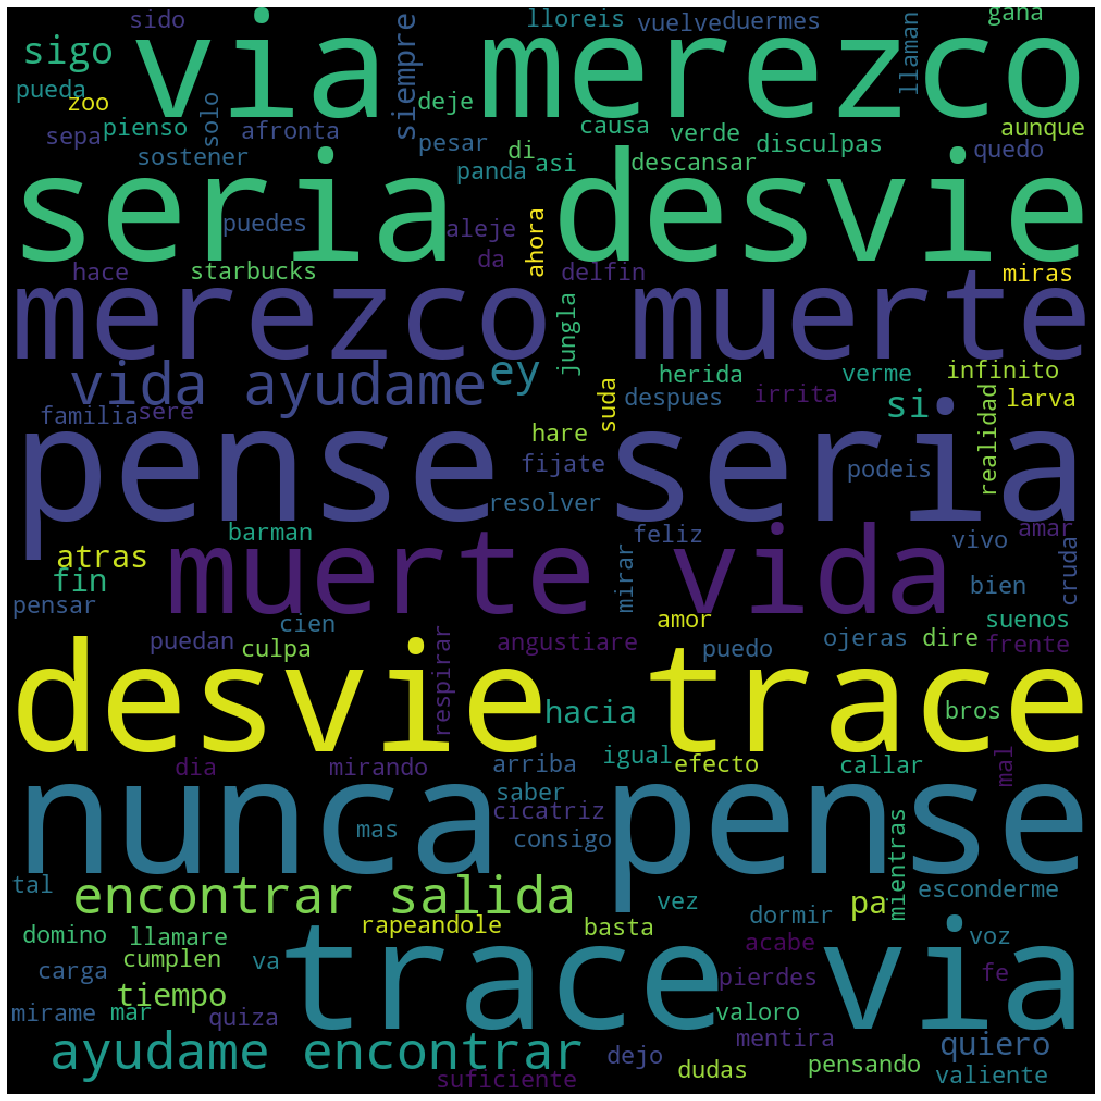

In [78]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 1000, height = 1000,min_font_size = 10).generate(str(textos_limpios[0]))
fig = plt.figure(1, figsize=(20, 20))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


#### Dibujar el wordcloud de todos los textos que hay en nuestro corpus

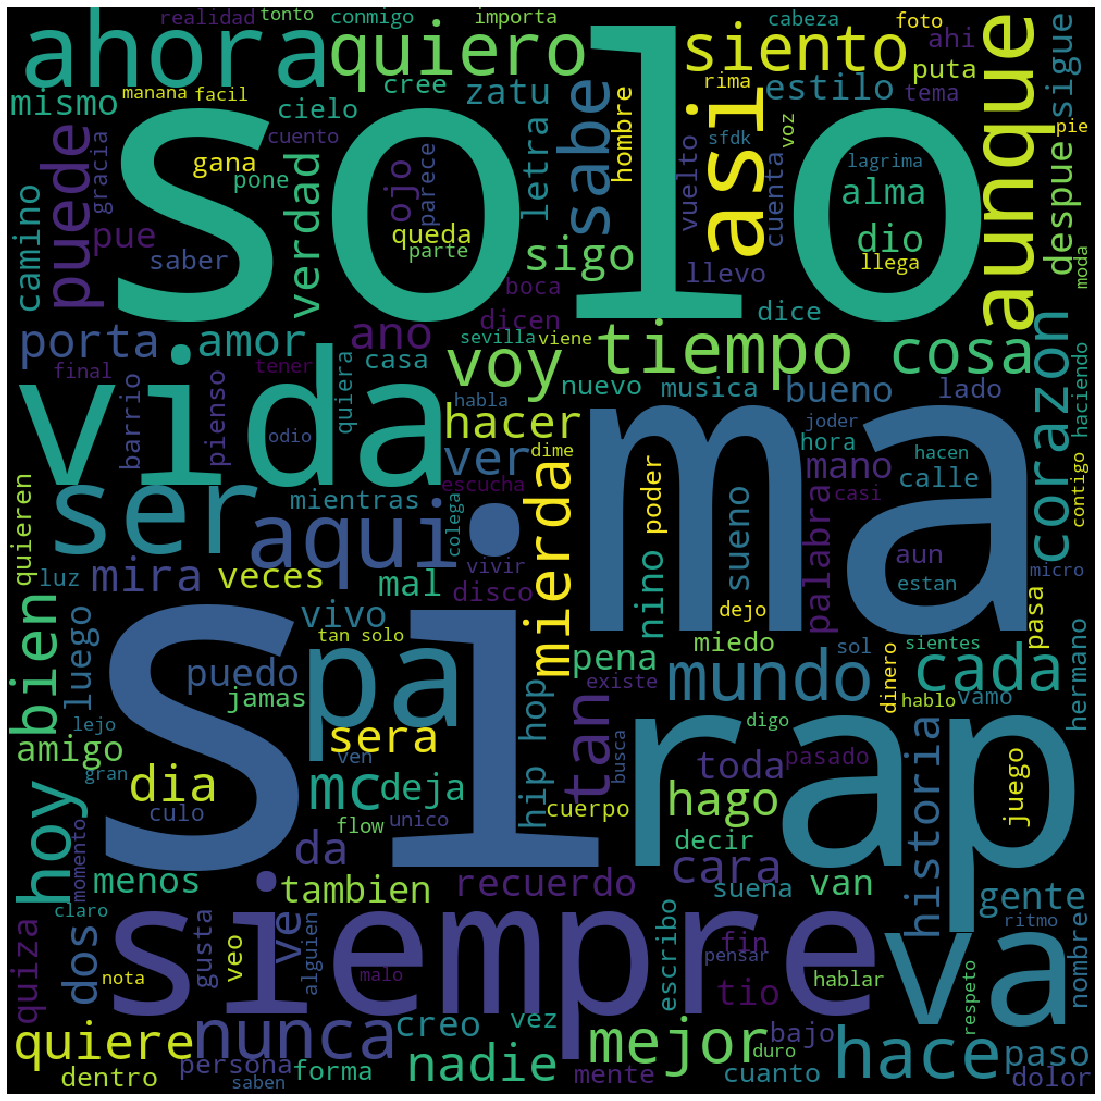

In [91]:
wordcloud = WordCloud(width = 1000, height = 1000,min_font_size = 10).generate(str(" ".join(textos_limpios)))
fig = plt.figure(1, figsize=(20, 20))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Obtener los k términos más importantes

Para esto tendréis que basaros en la lista de features de la nueva matriz y en la matriz tfidf

In [90]:
feature_array = np.array(tfidfconverter.get_feature_names())
tfidf_sorting = np.argsort(X).flatten()[::-1]
n = 3
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['ser', 'menos', 'amor'], dtype='<U8')

#### Un poquito de clustering a ver que tal ;)

Lo mismo que en la sesión de clustering, buscar los clusters que obtenemos, busquemos entre 2 y 15

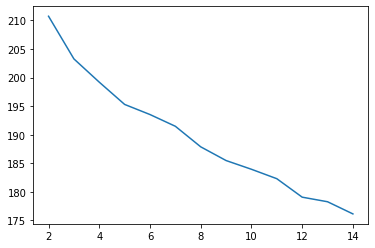

In [96]:
from sklearn.cluster import KMeans
import seaborn as sns
scores = []
k_values = range(2,15)
for a in k_values:
    kmeans = KMeans(n_clusters=a, random_state=0).fit(X)
    scores.append(kmeans.inertia_)
    
sns.lineplot(x=k_values, y=scores)

Si pintamos el factorplot igual que el otro dia, ¿Quedará igual de bien?

/home/nanirg/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


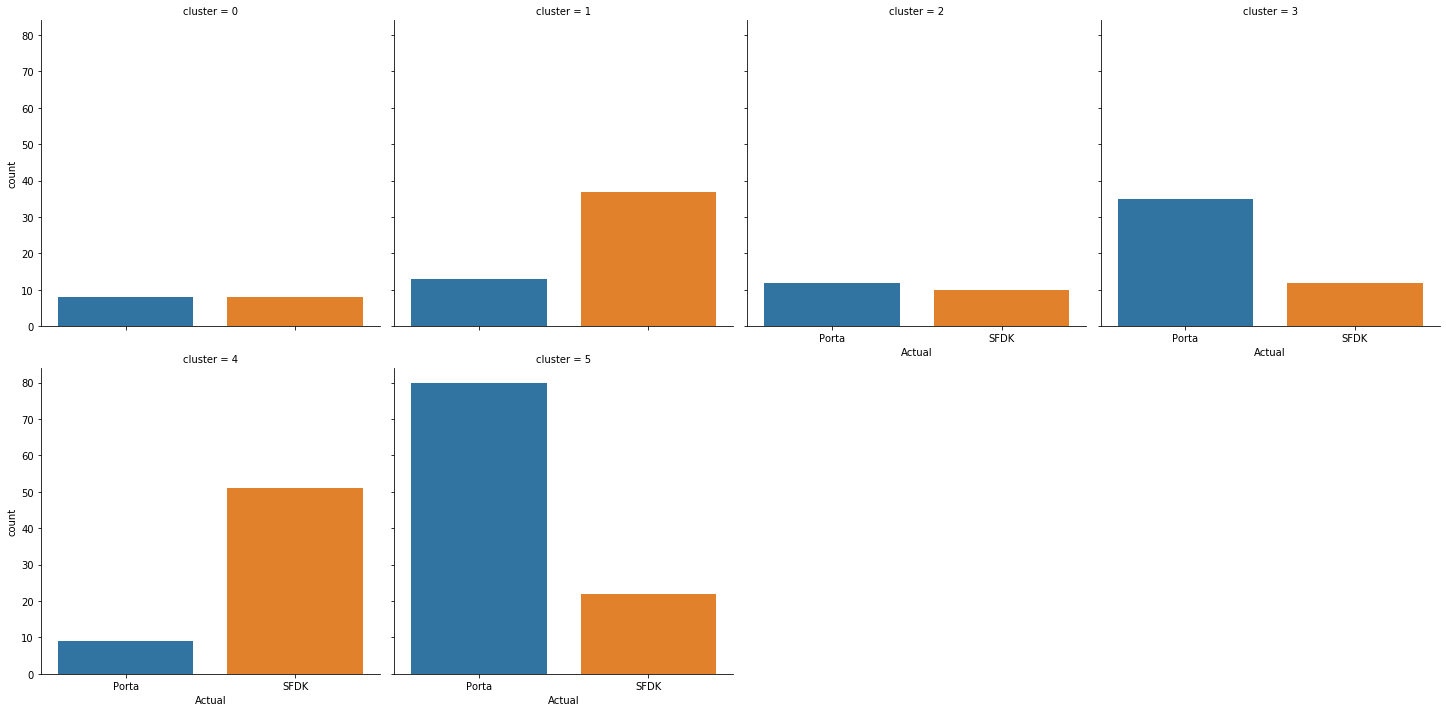

In [98]:
# Aprender Kmeans con el valor de K obtenido

kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

# Preparar el factorplot
cluster_result = pd.DataFrame()
cluster_result['cluster'] = kmeans.predict(X)
cluster_result['Actual'] = artista

ax = sns.factorplot(col='cluster', x='Actual', data=cluster_result, kind='count',col_wrap=4)

Vamos a pintar el conjunto de datos. Dos dibujos son particularmente importantes: 
1. Un scatterplot coloreado conlas etiquetas reales
2. Un scatterplot con el número de clusters que hayamos elegido

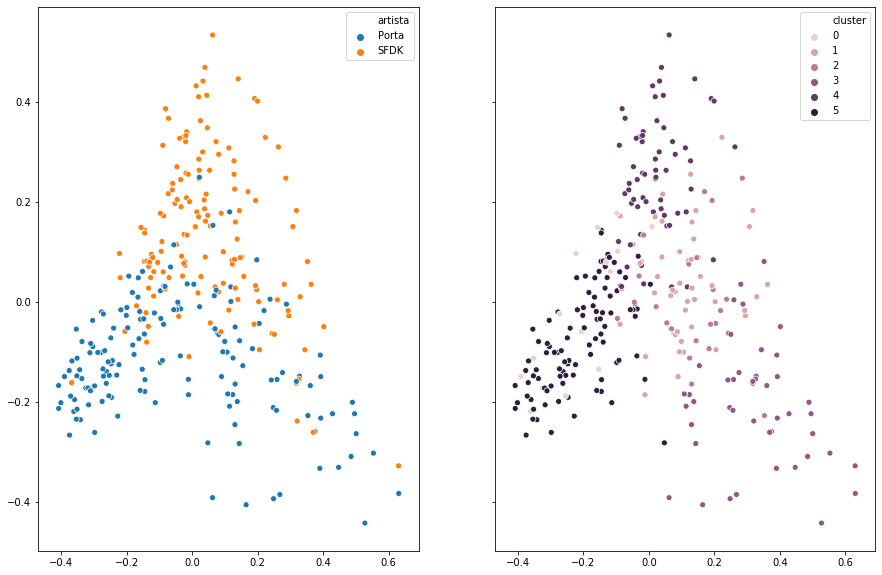

In [106]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
pintar = pca.transform(X)


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,10))
dib1 = sns.scatterplot(x = pintar[:,0], y = pintar[:,1], hue = cluster_result['cluster'] , legend = "full", ax = ax2)
dib2 = sns.scatterplot(x = pintar[:,0], y = pintar[:,1], hue = artista , legend = "full", ax = ax1)


Vaya parece, que no sacamos mucho de Kmeans, asi que habrá que acudir a un clasificador a ver qué tal nos resuelve la papeleta

## 3 - Entrenamiento!

#### Partir el conjunto de entrenamiento

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, artista, test_size=0.33, random_state=42)

#### Entrenar un clasificador y sacar el accuracy

In [108]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 50) # Una mera prueba, yo le metí 50 en un primer intento
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.9292929292929293

#### Dibujar la amtriz de confusion

[[48  4]
 [ 3 44]]


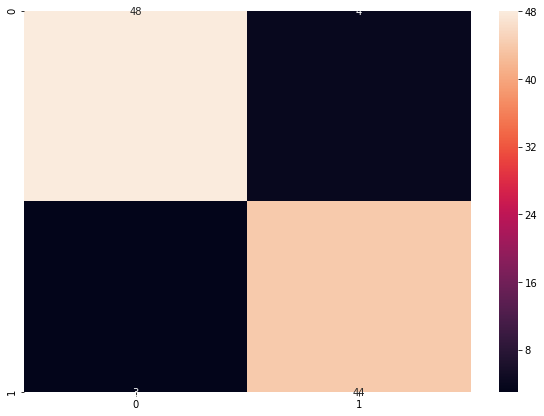

In [122]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
cnfm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cnfm, annot= True)

print(cnfm)



## 4 - Aventura: ¿Ya pensabais que se acababa aquí no?

Como habéis podido ver, hemos usado solo la info básica, pero hay mucho que ajustar en lo que el texto se refiere. Se pueden añadir variables artificiales en base a las etiquetas que hemos quitado antes (corchetes y llaves). Os dejo esto ya a vuestra imaginación. No hay guía, no me he basado en ningún kernel, esto es campo abierto y un divertimento para vosotros, sorprendedme ;)


![title](./tenor.gif)

In [ ]:
# ADVENTURE